# Microsoft Malware detection


In [1]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

<a id="1"></a> <br>
## 2. Loading the data

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics
# Plotly library
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 500)

from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import gc
from catboost import CatBoostClassifier

_catboost


<a id="2.1"></a> <br>
### 2.1 Get the files and select the variables

In [3]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

First, we make a census of the variables, by type, and define the set we want to keep before reading the data:

In [4]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
categorical_columns = [c for c,v in dtypes.items() if v not in numerics]

We read the data, limiting the size of the training set to 4'000'000 rows:

In [5]:
nrows = None
#nrows = 40000

retained_columns = numerical_columns + categorical_columns
train = pd.read_csv('./inputs/train.csv',
                    nrows = nrows,
                    usecols = retained_columns,
                    dtype = dtypes)
train = reduce_mem_usage(train)


Mem. usage decreased to 1673.25 Mb (0.0% reduction)


In [6]:
gc.collect()

228711

In [7]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
28,PuaMode,2,99.974119,99.974119,category
41,Census_ProcessorClass,3,99.589407,99.589407,category
8,DefaultBrowsersIdentifier,1730,95.141637,95.141637,float16
68,Census_IsFlightingInternal,2,83.044030,83.044030,float16
52,Census_InternalBatteryType,78,71.046809,71.046809,category
71,Census_ThresholdOptIn,2,63.524472,63.524472,float16
75,Census_IsWIMBootEnabled,2,63.439038,63.439038,float16
31,SmartScreen,21,35.610795,48.379658,category
15,OrganizationIdentifier,49,30.841487,47.037662,float16
29,SMode,2,6.027686,93.928812,float16


In [8]:
stats_df.to_csv('stats.csv')

In [9]:
#len(train.columns)
#train['AVProductsEnabled']
#train['MachineIdentifier'].nunique()                  

In [10]:
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9 and col not in ['ProductName','Processor','Census_HasOpticalDiskDrive', 'DefaultBrowsersIdentifier','Firewall', 'IsProtected', 'AVProductsEnabled', 'Census_GenuineStateName']:
        good_cols.remove(col)

In [11]:
train = train[good_cols]

In [12]:
retained_columns += ['MachineIdentifier']
retained_columns.remove('HasDetections')

test = pd.read_csv('./inputs/test.csv',
                   nrows = nrows,
                   usecols = retained_columns,
                   dtype = dtypes)

#
test['OsBuildLab'] = test['OsBuildLab'].fillna('17134.1.amd64fre.rs4_release.180410-1804')

test = reduce_mem_usage(test)

Mem. usage decreased to 1503.79 Mb (0.0% reduction)


In [13]:
test.loc[6529507, 'OsBuildLab'] = '17134.1.amd64fre.rs4_release.180410-1804'

In [14]:
cnt = np.load('./inputs/ver_updated_defs_count.npy').item()
max(dict(cnt).values())

datedict = np.load('./inputs/AvSigVersionTimestamps.npy')[()]
datedictOS = np.load('./inputs/OSVersionTimestamps.npy')[()]

from collections import OrderedDict

sorted_OS = OrderedDict(sorted(datedictOS.items(), key=lambda x: x[1]))
final_OS  = OrderedDict()

for idx,val in tqdm(enumerate(sorted_OS)):
    final_OS[val[0:]] = (val.split('.')[2], idx)
final_OS_ = OrderedDict(sorted(final_OS.items(), key=lambda x: x[1]))

datedictOS_idx = OrderedDict()
for idx,val in tqdm(enumerate(final_OS_)):
    try:
        datedictOS_idx[val.split('.')[2]+'.'+val.split('.')[3]] = idx
    except:
        datedictOS_idx[val.split('.')[1]+'.'+val.split('.')[2]] = idx
        #print(val)
del final_OS_, final_OS
gc.collect()

def split_sig(sigs):
    """Split the signature given as string into a 4-tuple of integers."""
    return tuple(int(part) for part in sigs.replace('1.2&#x17;3.1144.0','1.273.1144.0').split('.'))

def my_key(item):
    return split_sig(item[0])

items = dict(sorted(datedict.items(), key=my_key))

324it [00:00, 338300.85it/s]
324it [00:00, 333485.77it/s]


In [15]:
good_cols.remove('HasDetections')
test = test[good_cols]


In [16]:
good_cols.append('HasDetections')

In [17]:
print(train.shape)
print(test.shape)

(8921483, 64)
(7853253, 63)


In [18]:
new_map, cnt = {}, 0
for key in tqdm(items.keys()):
    new_map[key] = cnt
    cnt +=1

#Time Sereis EDA Kernel by Chris
#https://www.kaggle.com/cdeotte/time-series-eda-malware-0-64
# FEATURE ENGINEER - WEEK
first = datetime.datetime(2016,1,1); datedict2 = {}
for x in datedict: datedict2[x] = (datedict[x]-first).days//7
train['Week_2016'] = train['AvSigVersion'].map(datedict2)
test['Week_2016'] = test['AvSigVersion'].map(datedict2)

# FEATURE ENGINEER - WEEK
first = datetime.datetime(2018,1,1); datedict2 = {}
for x in datedict: datedict2[x] = (datedict[x]-first).days//7
train['Week_2018'] = train['AvSigVersion'].map(datedict2)
test['Week_2018'] = test['AvSigVersion'].map(datedict2)

train['sort'] = train['AvSigVersion'].map(new_map)
test['sort'] = test['AvSigVersion'].map(new_map)


train['x1'] = train['OsBuildLab'].apply(lambda x: x.split('.')[0] +'.'+ x.split('.')[1])
train['x2'] = train['Census_OSVersion'].apply(lambda x: x.split('.')[2] +'.'+ x.split('.')[3])

train['temp_x1'] = train['x1'].map(datedictOS_idx)
train['temp_x2'] = train['x2'].map(datedictOS_idx)
train['temp_diffs'] = abs(train['temp_x2'] - train['temp_x1'])

test['x1'] = test['OsBuildLab'].apply(lambda x: x.split('.')[0] +'.'+ x.split('.')[1])
test['x2'] = test['Census_OSVersion'].apply(lambda x: x.split('.')[2] +'.'+ x.split('.')[3])
test['temp_x1'] = test['x1'].map(datedictOS_idx)
test['temp_x2'] = test['x2'].map(datedictOS_idx)
test['temp_diffs'] = abs(test['temp_x2'] - test['temp_x1'])

del train['temp_x1'], train['temp_x2'], train['x1'], train['x2'], test['temp_x1'], test['temp_x2'], test['x1'], test['x2']
del first, datedict, datedict2
gc.collect()

100%|█████████████████████████████████████████████████████████████████████████| 9622/9622 [00:00<00:00, 1374109.40it/s]


217

In [19]:
all_dates = np.load('./inputs/all_dates_v2.npy').item()
months={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}

In [20]:
test['release_dates'] = test['AvSigVersion'].map(all_dates)
test['release_dates'] = test['release_dates'].astype(str)
test['year'] = test['release_dates'].apply(lambda x: x[7:11])
test.drop('release_dates', axis=1, inplace=True)
gc.collect()

28

In [21]:
train['release_dates'] = train['AvSigVersion'].map(all_dates)
train['year'] = train['release_dates'].apply(lambda x: x[7:11])
train.drop('release_dates', axis=1, inplace=True)



In [22]:
sig_2018 = np.asarray(list(set(train[(train['year'] == '2017') | (train['year'] == '2018')]['AvSigVersion'].values)))
gc.collect()
print(len(sig_2018))

5920


In [23]:
train['AVProductStatesIdentifier'] = train['AVProductStatesIdentifier'].astype('category')
test['AVProductStatesIdentifier'] = test['AVProductStatesIdentifier'].astype('category')
train['AVProductsInstalled'] = train['AVProductsInstalled'].astype('category')
test['AVProductsInstalled'] = test['AVProductsInstalled'].astype('category')
train['CountryIdentifier'] = train['CountryIdentifier'].astype('category')
test['CountryIdentifier'] = test['CountryIdentifier'].astype('category')
train['CityIdentifier'] = train['CityIdentifier'].astype('category')
test['CityIdentifier'] = test['CityIdentifier'].astype('category')
train['OrganizationIdentifier'] = train['OrganizationIdentifier'].astype('category')
test['OrganizationIdentifier'] = test['OrganizationIdentifier'].astype('category')
train['GeoNameIdentifier'] = train['GeoNameIdentifier'].astype('category')
test['GeoNameIdentifier'] = test['GeoNameIdentifier'].astype('category')

train['LocaleEnglishNameIdentifier'] = train['LocaleEnglishNameIdentifier'].astype('category')
test['LocaleEnglishNameIdentifier'] = test['LocaleEnglishNameIdentifier'].astype('category')

train['IeVerIdentifier'] = train['IeVerIdentifier'].astype('category')
test['IeVerIdentifier'] = test['IeVerIdentifier'].astype('category')

train['Census_OEMNameIdentifier'] = train['Census_OEMNameIdentifier'].astype('category')
test['Census_OEMNameIdentifier'] = test['Census_OEMNameIdentifier'].astype('category')

train['Census_OEMModelIdentifier'] = train['Census_OEMModelIdentifier'].astype('category')
test['Census_OEMModelIdentifier'] = test['Census_OEMModelIdentifier'].astype('category')

train['Census_ProcessorModelIdentifier'] = train['Census_ProcessorModelIdentifier'].astype('category')
test['Census_ProcessorModelIdentifier'] = test['Census_ProcessorModelIdentifier'].astype('category')

train['Census_InternalBatteryNumberOfCharges'] = train['Census_InternalBatteryNumberOfCharges'].astype('category')
test['Census_InternalBatteryNumberOfCharges'] = test['Census_InternalBatteryNumberOfCharges'].astype('category')

train['Census_OSBuildNumber'] = train['Census_OSBuildNumber'].astype('category')
test['Census_OSBuildNumber'] = test['Census_OSBuildNumber'].astype('category')

train['Census_OSBuildRevision'] = train['Census_OSBuildRevision'].astype('category')
test['Census_OSBuildRevision'] = test['Census_OSBuildRevision'].astype('category')

train['Census_FirmwareManufacturerIdentifier'] = train['Census_FirmwareManufacturerIdentifier'].astype('category')
test['Census_FirmwareManufacturerIdentifier'] = test['Census_FirmwareManufacturerIdentifier'].astype('category')

train['Census_FirmwareVersionIdentifier'] = train['Census_FirmwareVersionIdentifier'].astype('category')
test['Census_FirmwareVersionIdentifier'] = test['Census_FirmwareVersionIdentifier'].astype('category')

train['OsBuild'] = train['OsBuild'].astype('category')
test['OsBuild'] = test['OsBuild'].astype('category')

In [24]:
#public kernel (will fix the link)
train.SmartScreen=train.SmartScreen.str.lower()
train.SmartScreen.replace({"promt":"prompt",
                        "promprt":"prompt",
                        "00000000":"0",
                        "enabled":"on",
                        "of":"off" ,
                        "deny":"0" , # just one
                        "requiredadmin":"requireadmin"
                       },inplace=True)
train.SmartScreen = train.SmartScreen.astype("category")

test.SmartScreen = test.SmartScreen.str.lower()
test.SmartScreen.replace({"promt":"prompt",
                        "promprt":"prompt",
                        "00000000":"0",
                        "enabled":"on",
                        "of":"off" ,
                        "deny":"0" , # just one
                        "requiredadmin":"requireadmin"
                       },inplace=True)
test.SmartScreen = test.SmartScreen.astype("category")

In [25]:
train['fe_avsig_org_freq']        = train[['AvSigVersion','OrganizationIdentifier','OsBuild']].groupby(['AvSigVersion','OrganizationIdentifier'])['OsBuild'].transform('count') / train.shape[0]
train['fe_avsig_cty_freq']        = train[['AvSigVersion','CityIdentifier','OsBuild']].groupby(['AvSigVersion','CityIdentifier'])['OsBuild'].transform('count') / train.shape[0]
train['fe_avsig_gamer_freq']      = train[['AvSigVersion','Wdft_IsGamer', 'OsBuild']].groupby(['AvSigVersion','Wdft_IsGamer'])['OsBuild'].transform('count') / train.shape[0]
train['fe_cpucores_region_freq']  = train[['Census_ProcessorCoreCount','Wdft_RegionIdentifier','OsBuild']].groupby(['Census_ProcessorCoreCount','Wdft_RegionIdentifier'])['OsBuild'].transform('count') / train.shape[0]

test['fe_avsig_org_freq']        = test[['AvSigVersion','OrganizationIdentifier','OsBuild']].groupby(['AvSigVersion','OrganizationIdentifier'])['OsBuild'].transform('count') / test.shape[0]
test['fe_avsig_cty_freq']        = test[['AvSigVersion','CityIdentifier','OsBuild']].groupby(['AvSigVersion','CityIdentifier'])['OsBuild'].transform('count') / test.shape[0]
test['fe_avsig_gamer_freq']      = test[['AvSigVersion','Wdft_IsGamer', 'OsBuild']].groupby(['AvSigVersion','Wdft_IsGamer'])['OsBuild'].transform('count') / test.shape[0]
test['fe_cpucores_region_freq']  = test[['Census_ProcessorCoreCount','Wdft_RegionIdentifier','OsBuild']].groupby(['Census_ProcessorCoreCount','Wdft_RegionIdentifier'])['OsBuild'].transform('count') / test.shape[0]

In [26]:
print(gc.collect())
train['AvSigVersion'] = train['AvSigVersion'].replace(r'[^\.|0-9]','1.273.1826.0')

train['OsBuild_exact'] = train['OsBuildLab'].apply(lambda x: x.split('.')[0] +'.'+ x.split('.')[1])
train['OsBuild_exact'] = train['OsBuild_exact'].astype('category')


119


In [27]:
test['AvSigVersion'] = test['AvSigVersion'].replace(r'[^\.|0-9]','1.273.1826.0')
train['AvSigVersion'] = train['AvSigVersion'].replace(r'[^\.|0-9]','1.273.1826.0')
train['AvSigVersion'] = train['AvSigVersion'].str.replace(r'2&#x17;3','1.273.1826.0')

test['OsBuild_exact']  =  test['OsBuildLab'].apply(lambda x: x.split('.')[0] +'.'+ x.split('.')[1])
test['OsBuild_exact']  = test['OsBuild_exact'].astype('category')


In [28]:
train['no_av_at_risk'] = 0
train.loc[train['AVProductsEnabled'].isin([0]) == True, 'no_av_at_risk'] = 1

test['no_av_at_risk'] = 0
test.loc[test['AVProductsEnabled'].isin([0]) == True, 'no_av_at_risk'] = 1

train['not_genuine_user'] = 0
train.loc[train['Census_GenuineStateName'].isin(['IS_GENUINE']) == False, 'not_genuine_user'] = 1

test['not_genuine_user'] = 0
test.loc[test['Census_GenuineStateName'].isin(['IS_GENUINE']) == False, 'not_genuine_user'] = 1


train['AvSigVersion_sum'] = train['AvSigVersion'].apply(lambda x: float(x.split('.')[1]) + float(x.split('.')[2])).astype(int).values
test['AvSigVersion_sum'] = test['AvSigVersion'].apply(lambda x: float(x.split('.')[1]) + float(x.split('.')[2])).astype(int).values

train['AvSigVersion'] = train['AvSigVersion'].astype('category')
test['AvSigVersion'] = test['AvSigVersion'].astype('category')

train['OsBuild_exact'] = train['OsBuildLab'].apply(lambda x: x.split('.')[0] +'.'+ x.split('.')[1])
test['OsBuild_exact']  =  test['OsBuildLab'].apply(lambda x: x.split('.')[0] +'.'+ x.split('.')[1])

train['OsBuild_exact'] = train['OsBuild_exact'].astype('category')
test['OsBuild_exact']  = test['OsBuild_exact'].astype('category')

top_20 = train['AVProductStatesIdentifier'].value_counts(dropna=False, normalize=True).cumsum().index[:20]
train['magic_4'] = 0
test['magic_4']  = 0
train.loc[train['AVProductStatesIdentifier'].isin(top_20) == True, 'magic_4'] = 1
test.loc[test['AVProductStatesIdentifier'].isin(top_20) == True, 'magic_4']   = 1
del top_20
gc.collect()

105

In [29]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 1674.61 Mb (26.5% reduction)
Mem. usage decreased to 1505.16 Mb (26.1% reduction)


In [30]:
# https://www.kaggle.com/youhanlee/my-eda-i-want-to-see-all
# grouping battary types by name
def group_battery(x):
    x = x.lower()
    if 'li' in x:
        return 1
    else:
        return 0
    
train['Census_InternalBatteryType'] = train['Census_InternalBatteryType'].apply(group_battery)
test['Census_InternalBatteryType'] = test['Census_InternalBatteryType'].apply(group_battery)

In [31]:
def rename_edition(x):
    x = x.lower()
    if 'core' in x:
        return 'Core'
    elif 'pro' in x:
        return 'pro'
    elif 'enterprise' in x:
        return 'Enterprise'
    elif 'server' in x:
        return 'Server'
    elif 'home' in x:
        return 'Home'
    elif 'education' in x:
        return 'Education'
    elif 'cloud' in x:
        return 'Cloud'
    else:
        return x

In [32]:
train['Census_OSEdition'] = train['Census_OSEdition'].astype(str)
test['Census_OSEdition'] = test['Census_OSEdition'].astype(str)
train['Census_OSEdition'] = train['Census_OSEdition'].apply(rename_edition)
test['Census_OSEdition'] = test['Census_OSEdition'].apply(rename_edition)
train['Census_OSEdition'] = train['Census_OSEdition'].astype('category')
test['Census_OSEdition'] = test['Census_OSEdition'].astype('category')

In [33]:
train['Census_OSSkuName'] = train['Census_OSSkuName'].astype(str)
test['Census_OSSkuName'] = test['Census_OSSkuName'].astype(str)
train['Census_OSSkuName'] = train['Census_OSSkuName'].apply(rename_edition)
test['Census_OSSkuName'] = test['Census_OSSkuName'].apply(rename_edition)
train['Census_OSSkuName'] = train['Census_OSSkuName'].astype('category')
test['Census_OSSkuName'] = test['Census_OSSkuName'].astype('category')

In [34]:
train['Census_OSInstallLanguageIdentifier'] = train['Census_OSInstallLanguageIdentifier'].astype('category')
test['Census_OSInstallLanguageIdentifier'] = test['Census_OSInstallLanguageIdentifier'].astype('category')

In [35]:
train['Census_OSUILocaleIdentifier'] = train['Census_OSUILocaleIdentifier'].astype('category')
test['Census_OSUILocaleIdentifier'] = test['Census_OSUILocaleIdentifier'].astype('category')

In [36]:
train['OsSuite'] = train['OsSuite'].astype('category')
test['OsSuite'] = test['OsSuite'].astype('category')
train['Wdft_RegionIdentifier'] = train['Wdft_RegionIdentifier'].astype('category')
test['Wdft_RegionIdentifier'] = test['Wdft_RegionIdentifier'].astype('category')

In [37]:
pd.crosstab(train['SkuEdition'], train['Census_OSEdition'], normalize='columns')

Census_OSEdition,Cloud,Core,Education,Enterprise,Home,Server,pro,ultimate
SkuEdition,,,,,,,,
Cloud,0.888429,7.160321e-07,0.000000,0.000000,0.000000,0.000000,9.328509e-07,0.0
Education,0.000000,1.521568e-05,0.966952,0.000000,0.000000,0.000000,1.085217e-04,0.0
Enterprise,0.000000,2.148096e-06,0.000024,0.603117,0.000000,0.000139,1.648037e-05,0.0
Enterprise LTSB,0.000000,5.370240e-07,0.000048,0.363763,0.000000,0.000000,4.975205e-06,0.0
Home,0.001751,9.860368e-01,0.003843,0.001706,0.166667,0.000416,1.780812e-03,0.0
Invalid,0.000000,8.670432e-03,0.000360,0.000000,0.166667,0.748525,5.849286e-03,1.0
Pro,0.109820,5.274113e-03,0.028773,0.031379,0.666667,0.002498,9.922390e-01,0.0
Server,0.000000,0.000000e+00,0.000000,0.000035,0.000000,0.248421,0.000000e+00,0.0


In [38]:
train['SmartScreen'].value_counts(dropna=False, normalize=True).cumsum()
test['SmartScreen'].value_counts(dropna=False, normalize=True).cumsum()

NaN             0.445472
requireadmin    0.880141
existsnotset    0.956600
off             0.977376
warn            0.993411
prompt          0.997090
block           0.999794
on              0.999914
&#x02;          0.999965
&#x01;          0.999999
0               1.000000
Name: SmartScreen, dtype: float64

In [39]:
train['OsBuildLab'] = train['OsBuildLab'].cat.add_categories(['0.0.0.0.0-0'])
train['OsBuildLab'] = train['OsBuildLab'].fillna('0.0.0.0.0-0')
test['OsBuildLab'] = test['OsBuildLab'].cat.add_categories(['0.0.0.0.0-0'])
test['OsBuildLab'] = test['OsBuildLab'].fillna('0.0.0.0.0-0')

In [40]:
train['AvSigVersion'].head()

0    1.273.1735.0
1      1.263.48.0
2    1.273.1341.0
3    1.273.1527.0
4    1.273.1379.0
Name: AvSigVersion, dtype: category
Categories (8531, object): [0.0.0.0, 1.1.273.1826.0.1144.0, 1.155.266.0, 1.167.387.0, ..., 1.277.58.0, 1.277.62.0, 1.277.64.0, 1.277.67.0]

In [41]:
train['AvSigVersion_0'] = train['AvSigVersion'].apply(lambda x: x.split('.')[0]).astype('category')
#train['AvSigVersion_1'] = train['AvSigVersion'].apply(lambda x: x.split('.')[1]).astype('category')
#train['AvSigVersion_2'] = train['AvSigVersion'].apply(lambda x: x.split('.')[2]).astype('category')


In [42]:
def fe(df):
    df['EngineVersion_2'] = df['EngineVersion'].apply(lambda x: x.split('.')[2]).astype('category')
    df['EngineVersion_3'] = df['EngineVersion'].apply(lambda x: x.split('.')[3]).astype('category')

    df['AppVersion_1'] = df['AppVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    df['AppVersion_2'] = df['AppVersion'].apply(lambda x: x.split('.')[2]).astype('category')
    df['AppVersion_3'] = df['AppVersion'].apply(lambda x: x.split('.')[3]).astype('category')
    
    df['AvSigVersion'] = df['AvSigVersion'].astype('category')

    df['AvSigVersion_0'] = df['AvSigVersion'].apply(lambda x: x.split('.')[0]).astype('category')
    df['AvSigVersion_1'] = df['AvSigVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    df['AvSigVersion_2'] = df['AvSigVersion'].apply(lambda x: x.split('.')[2]).astype('category')

    df['OsBuildLab_0'] = df['OsBuildLab'].apply(lambda x: x.split('.')[0]).astype('category')
    df['OsBuildLab_1'] = df['OsBuildLab'].apply(lambda x: x.split('.')[1]).astype('category')
    df['OsBuildLab_2'] = df['OsBuildLab'].apply(lambda x: x.split('.')[2]).astype('category')
    df['OsBuildLab_3'] = df['OsBuildLab'].apply(lambda x: x.split('.')[3]).astype('category')
    # df['OsBuildLab_40'] = df['OsBuildLab'].apply(lambda x: x.split('.')[-1].split('-')[0]).astype('category')
    # df['OsBuildLab_41'] = df['OsBuildLab'].apply(lambda x: x.split('.')[-1].split('-')[1]).astype('category')

    df['Census_OSVersion_0'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[0]).astype('category')
    df['Census_OSVersion_1'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    df['Census_OSVersion_2'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[2]).astype('category')
    df['Census_OSVersion_3'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[3]).astype('category')

    # https://www.kaggle.com/adityaecdrid/simple-feature-engineering-xd
    df['primary_drive_c_ratio'] = df['Census_SystemVolumeTotalCapacity']/ df['Census_PrimaryDiskTotalCapacity']
    df['non_primary_drive_MB'] = df['Census_PrimaryDiskTotalCapacity'] - df['Census_SystemVolumeTotalCapacity']

    df['aspect_ratio'] = df['Census_InternalPrimaryDisplayResolutionHorizontal']/ df['Census_InternalPrimaryDisplayResolutionVertical']

    df['monitor_dims'] = df['Census_InternalPrimaryDisplayResolutionHorizontal'].astype(str) + '*' + df['Census_InternalPrimaryDisplayResolutionVertical'].astype('str')
    df['monitor_dims'] = df['monitor_dims'].astype('category')

    df['dpi'] = ((df['Census_InternalPrimaryDisplayResolutionHorizontal']**2 + df['Census_InternalPrimaryDisplayResolutionVertical']**2)**.5)/(df['Census_InternalPrimaryDiagonalDisplaySizeInInches'])

    df['dpi_square'] = df['dpi'] ** 2

    df['MegaPixels'] = (df['Census_InternalPrimaryDisplayResolutionHorizontal'] * df['Census_InternalPrimaryDisplayResolutionVertical'])/1e6

    df['Screen_Area'] = (df['aspect_ratio']* (df['Census_InternalPrimaryDiagonalDisplaySizeInInches']**2))/(df['aspect_ratio']**2 + 1)

    df['ram_per_processor'] = df['Census_TotalPhysicalRAM']/ df['Census_ProcessorCoreCount']

    df['new_num_0'] = df['Census_InternalPrimaryDiagonalDisplaySizeInInches'] / df['Census_ProcessorCoreCount']

    df['new_num_1'] = df['Census_ProcessorCoreCount'] * df['Census_InternalPrimaryDiagonalDisplaySizeInInches']
    
    df['Census_IsFlightingInternal'] = df['Census_IsFlightingInternal'].fillna(1)
    df['Census_ThresholdOptIn'] = df['Census_ThresholdOptIn'].fillna(1)
    df['Census_IsWIMBootEnabled'] = df['Census_IsWIMBootEnabled'].fillna(1)
    df['Wdft_IsGamer'] = df['Wdft_IsGamer'].fillna(0)
    
    return df

In [43]:
train['physical_cores'] = train['Census_ProcessorCoreCount'] / 2
test['physical_cores']  = test['Census_ProcessorCoreCount'] / 2

train['hghdec_cnt'] = 0
test['hghdec_cnt'] = 0

train.loc[train['CountryIdentifier'].isin([104,95,214,89,94,59,21,100,85,195,159,57,155,188,33,44,18,88,81,205,141]) == True, 'hghdec_cnt'] = 1
test.loc[test['CountryIdentifier'].isin([104,95,214,89,94,59,21,100,85,195,159,57,155,188,33,44,18,88,81,205,141]) == True, 'hghdec_cnt'] = 1;

In [44]:
train['SmartScreen_dummy'] = 0
test['SmartScreen_dummy'] = 0

train.loc[train['SmartScreen'].isin(['ExistsNotSet', 'RequireAdmin', 'Warn']) == True, 'SmartScreen_dummy'] = 1
test.loc[test['SmartScreen'].isin(['ExistsNotSet', 'RequireAdmin', 'Warn']) == True, 'SmartScreen_dummy'] = 1;

#train['one_less_AVproductInstalled'] = train['AVProductsInstalled'] - 1
#test['one_less_AVproductInstalled'] = test['AVProductsInstalled'] - 1

In [45]:
train['Census_ProcessorModelIdentifier'] = train['Census_ProcessorModelIdentifier'].astype('category')
test['Census_ProcessorModelIdentifier']  = test['Census_ProcessorModelIdentifier'].astype('category')

In [46]:
top_10 = train['Census_TotalPhysicalRAM'].value_counts(dropna=False, normalize=True).cumsum().index[:10]
train.loc[train['Census_TotalPhysicalRAM'].isin(top_10) == False, 'Census_TotalPhysicalRAM'] = 1024
test.loc[test['Census_TotalPhysicalRAM'].isin(top_10) == False, 'Census_TotalPhysicalRAM']   = 1024
del top_10

In [47]:
def rename_edition(x):
    x = x.lower()
    if 'core' in x:
        return 'Core'
    elif 'pro' in x:
        return 'pro'
    elif 'enterprise' in x:
        return 'Enterprise'
    elif 'server' in x:
        return 'Server'
    elif 'home' in x:
        return 'Home'
    elif 'education' in x:
        return 'Education'
    elif 'cloud' in x:
        return 'Cloud'
    else:
        return x

In [48]:
train['Census_OSEdition'] = train['Census_OSEdition'].astype(str)
test['Census_OSEdition'] = test['Census_OSEdition'].astype(str)
train['Census_OSEdition'] = train['Census_OSEdition'].apply(rename_edition)
test['Census_OSEdition'] = test['Census_OSEdition'].apply(rename_edition)
train['Census_OSEdition'] = train['Census_OSEdition'].astype('category')
test['Census_OSEdition'] = test['Census_OSEdition'].astype('category')

In [49]:
train['Census_OSSkuName'] = train['Census_OSSkuName'].astype(str)
test['Census_OSSkuName'] = test['Census_OSSkuName'].astype(str)
train['Census_OSSkuName'] = train['Census_OSSkuName'].apply(rename_edition)
test['Census_OSSkuName'] = test['Census_OSSkuName'].apply(rename_edition)
train['Census_OSSkuName'] = train['Census_OSSkuName'].astype('category')
test['Census_OSSkuName'] = test['Census_OSSkuName'].astype('category')

In [50]:
train = fe(train)
test = fe(test)

In [51]:
cat_cols = [col for col in train.columns if col not in ['MachineIdentifier', 'Census_SystemVolumeTotalCapacity', 'HasDetections'] and str(train[col].dtype) == 'category']
len(cat_cols)

60

In [52]:
more_cat_cols = []
add_cat_feats = [
 'Census_OSBuildRevision',
 'OsBuildLab',
 'SmartScreen',
'AVProductsInstalled']
for col1 in add_cat_feats:
    for col2 in add_cat_feats:
        if col1 != col2:
            train[col1 + '__' + col2] = train[col1].astype(str) + train[col2].astype(str)
            train[col1 + '__' + col2] = train[col1 + '__' + col2].astype('category')
            
            test[col1 + '__' + col2] = test[col1].astype(str) + test[col2].astype(str)
            test[col1 + '__' + col2] = test[col1 + '__' + col2].astype('category')
            more_cat_cols.append(col1 + '__' + col2)
            
cat_cols = cat_cols + more_cat_cols

In [53]:
to_encode = []
for col in cat_cols:
    if train[col].nunique() > 1000:
        print(col, train[col].nunique())
        to_encode.append(col)

AvSigVersion 8531
AVProductStatesIdentifier 28970
CityIdentifier 107366
Census_OEMNameIdentifier 2564
Census_OEMModelIdentifier 175365
Census_ProcessorModelIdentifier 2583
Census_InternalBatteryNumberOfCharges 41087
Census_FirmwareVersionIdentifier 50494
AvSigVersion_2 2766
monitor_dims 10061
Census_OSBuildRevision__OsBuildLab 15367
Census_OSBuildRevision__SmartScreen 1620
Census_OSBuildRevision__AVProductsInstalled 1169
OsBuildLab__Census_OSBuildRevision 15367
OsBuildLab__SmartScreen 2218
OsBuildLab__AVProductsInstalled 1951
SmartScreen__Census_OSBuildRevision 1620
SmartScreen__OsBuildLab 2218
AVProductsInstalled__Census_OSBuildRevision 1169
AVProductsInstalled__OsBuildLab 1951


In [54]:
def frequency_encoding(variable):
    t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [55]:
# If you call encode_TE, encode_TE_partial, encode_FE_partial, 
# or encode_BE_partial on training data then the function 
# returns a 2 element python list containing [list, dictionary]
# the return[0] = list are the names of new columns added
# the return[1] = dictionary are which category variables got encoded
# When encoding test data after one of 4 calls above, use 'encode_?E_test'
# and pass the dictionary. If you don't use one of 4 above, then you can
# call basic 'encode_?E' on test.

# TARGET ENCODING
def encode_TE(df,col,tar='HasDetections'):
    d = {}
    v = df[col].unique()
    for x in v:
        if nan_check(x):
            m = df[tar][df[col].isna()].mean()
        else:
            m = df[tar][df[col]==x].mean()
        d[x] = m
    n = col+"_TE"
    df[n] = df[col].map(d)
    return [[n],d]

# TARGET ENCODING first ct columns by freq
def encode_TE_partial(df,col,ct,tar='HasDetections',xx=0.5):
    d = {}
    cv = df[col].value_counts(dropna=False)
    nm = cv.index.values[0:ct]
    for x in nm:
        if nan_check(x):
            m = df[tar][df[col].isna()].mean()
        else:
            m = df[tar][df[col]==x].mean()
        d[x] = m
    n = col+"_TE"
    df[n] = df[col].map(d).fillna(xx)
    return [[n],d]

# TARGET ENCODING from dictionary
def encode_TE_test(df,col,mp,xx=0.5):
    n = col+"_TE"
    df[n] = df[col].map(mp).fillna(xx)
    return [[n],0]

# FREQUENCY ENCODING
def encode_FE(df,col):
    d = df[col].value_counts(dropna=False)
    n = col+"_FE"
    df[n] = df[col].map(d)/d.max()
    return [[n],d]

# FREQUENCY ENCODING first ct columns by freq
def encode_FE_partial(df,col,ct):
    cv = df[col].value_counts(dropna=False)
    nm = cv.index.values[0:ct]
    n = col+"_FE"
    df[n] = df[col].map(cv)
    df.loc[~df[col].isin(nm),n] = np.mean(cv.values)
    df[n] = df[n] / max(cv.values)
    d = {}
    for x in nm: d[x] = cv[x]
    return [[n],d]

# FREQUENCY ENCODING from dictionary
def encode_FE_test(df,col,mp,xx=1.0):
    cv = df[col].value_counts(dropna=False)
    n = col+"_FE"
    df[n] = df[col].map(cv)
    df.loc[~df[col].isin(mp),n] = xx*np.mean(cv.values)
    df[n] = df[n] / max(cv.values)
    return [[n],mp]

# BINARY ENCODING
def encode_BE(df,col,val='xyz'):
    if val=='xyz':
        print('BE_encoding all')
        v = df[col].unique()
        n = []
        for x in v: n.append(encode_BE(df,col,x)[0][0])
        return [n,0]
    n = col+"_BE_"+str(val)
    if nan_check(val):
        df[n] = df[col].isna()
    elif isinstance(val, (list,)):
        if not isinstance(val[0], str):
            print('BE_encode Warning: val list not str')
        n = col+"_BE_"+str(val[0])+"_"+str(val[-1])
        d = {}
        for x in val: d[x]=1
        df[n] = df[col].map(d).fillna(0)
    else:
        if not isinstance(val, str):
            print('BE_encode Warning: val is not str')
        df[n] = df[col]==val
    df[n] = df[n].astype('int8')
    return [[n],0]

# BINARY ENCODING first ct columns by freq
def encode_BE_partial(df,col,ct):
    cv = df[col].value_counts(dropna=False)
    nm = cv.index.values[0:ct]
    d = {}
    n = []
    for x in nm: 
        n.append(encode_BE(df,col,x)[0][0])
        d[x] = 1
    return [n,d]

# BINARY ENCODING from dictionary
def encode_BE_test(df,col,mp):
    n = []
    for x in mp: n.append(encode_BE(df,col,x)[0][0])
    return [n,0]

# NUMERIC ENCODING
def encode_NE(df,col):
    n = col+"_NE"
    df[n] = df[col].astype(float)
    mx = np.std(df[n])
    mn = df[n].mean()
    df[n] = (df[n].fillna(mn) - mn) / mx
    return [[n],[mn,mx]]

# NUMERIC ENCODING from mean and std
def encode_NE_test(df,col,mm):
    n = col+"_NE"
    df[n] = df[col].astype(float)
    df[n] = (df[n].fillna(df[n].mean()) - mm[0]) / mm[1]
    return [[n],mm]

In [56]:
# INCREMENT A DATETIME
def add_time(sdate,months=0,days=0,hours=0):
    month = sdate.month -1 + months
    year = sdate.year + month // 12
    month = month % 12 + 1
    day = sdate.day + days
    if day>calendar.monthrange(year,month)[1]:
        day -= calendar.monthrange(year,month)[1]
        month += 1
        if month>12:
            month = 1
            year += 1
    hour = sdate.hour + hours
    if hour>23:
        hour = 0
        day += 1
        if day>calendar.monthrange(year,month)[1]:
            day -= calendar.monthrange(year,month)[1]
            month += 1
            if month>12:
                month = 1
                year += 1
    return datetime(year,month,day,hour,sdate.minute)

# CHECK FOR NAN
def nan_check(x):
    if isinstance(x,float):
        if math.isnan(x):
            return True
    return False

In [57]:
train['Census_IsTouchEnabled'] = train['Census_IsTouchEnabled'].astype('category')
test['Census_IsTouchEnabled'] = test['Census_IsTouchEnabled'].astype('category')

train['Processor'] = train['Processor'].astype('category')
test['Processor'] = test['Processor'].astype('category')

train['Census_HasOpticalDiskDrive'] = train['Census_HasOpticalDiskDrive'].astype('category')
test['Census_HasOpticalDiskDrive'] = test['Census_HasOpticalDiskDrive'].astype('category')

train['Census_InternalPrimaryDisplayResolutionVertical'] = train['Census_InternalPrimaryDisplayResolutionVertical'].astype('category')
test['Census_InternalPrimaryDisplayResolutionVertical'] = test['Census_InternalPrimaryDisplayResolutionVertical'].astype('category')

train['Census_PowerPlatformRoleName'] = train['Census_PowerPlatformRoleName'].astype('category')
test['Census_PowerPlatformRoleName'] = test['Census_PowerPlatformRoleName'].astype('category')

train['Wdft_IsGamer'] = train['Wdft_IsGamer'].astype('category')
test['Wdft_IsGamer'] = test['Wdft_IsGamer'].astype('category')


In [58]:
cols = []
import math

# NUMERIC ENCODE
cols += encode_NE(train,'Census_TotalPhysicalRAM')[0]
cols += encode_NE(train,'AVProductsInstalled')[0]
cols += encode_NE(train,'Census_ProcessorCoreCount')[0]

# CATEGORY ENCODE for logistic regression
tmp = encode_BE_partial(train,'SmartScreen',5)
cols += tmp[0]; dict_smartscreen = tmp[1]
tmp = encode_BE_partial(train,'AVProductStatesIdentifier',5)
cols += tmp[0]; dict_productstate = tmp[1]

# BINARY ENCODE
cols += encode_BE(train,'Processor','x86')[0]
cols += encode_BE(train,'Census_IsTouchEnabled','1')[0]
cols += encode_BE(train,'Census_HasOpticalDiskDrive','1')[0]
cols += encode_BE(train,'Census_InternalPrimaryDisplayResolutionVertical',['800','600'])[0]
cols += encode_BE(train,'Census_PowerPlatformRoleName','Slate')[0]
cols += encode_BE(train,'Wdft_IsGamer','1')[0]

#FREQUENCY ENCODE
cols += encode_FE(train,'Census_ProcessorModelIdentifier')[0]
cols += encode_FE(train,'Week_2016')[0]
cols += encode_FE(train,'Week_2018')[0]

#FREQUENCY ENCODE remove noise
tmp = encode_FE_partial(train,'Census_OSInstallTypeName',7)
cols += tmp[0]; dict_osinstalltype = tmp[1]

#TARGET ENCODE remove noise
tmp = encode_TE_partial(train,'CountryIdentifier',150)
cols += tmp[0]; dict_country = tmp[1]
tmp = encode_TE_partial(train,'OsBuild',5)
cols += tmp[0]; dict_osbuild = tmp[1]

BE_encode Warning: val is not str
BE_encode Warning: val is not str
BE_encode Warning: val is not str
BE_encode Warning: val is not str
BE_encode Warning: val is not str


In [59]:
cols = []

# NUMERIC ENCODE
cols += encode_NE(test,'Census_TotalPhysicalRAM')[0]
cols += encode_NE(test,'AVProductsInstalled')[0]
cols += encode_NE(test,'Census_ProcessorCoreCount')[0]

# CATEGORY ENCODE for logistic regression
cols += encode_BE_test(test,'SmartScreen',dict_smartscreen)[0]
cols += encode_BE_test(test,'AVProductStatesIdentifier',dict_productstate)[0] 

# BINARY ENCODE
cols += encode_BE(test,'Processor','x86')[0]
cols += encode_BE(test,'Census_IsTouchEnabled','1')[0]
cols += encode_BE(test,'Census_HasOpticalDiskDrive','1')[0]
cols += encode_BE(test,'Census_InternalPrimaryDisplayResolutionVertical',['800','600'])[0]
cols += encode_BE(test,'Census_PowerPlatformRoleName','Slate')[0]
cols += encode_BE(test,'Wdft_IsGamer','1')[0]

# FREQUENCY ENCODE
cols += encode_FE(test,'Census_ProcessorModelIdentifier')[0]
cols += encode_FE(test,'Week_2016')[0]
cols += encode_FE(test,'Week_2018')[0]
cols += encode_FE_test(test,'Census_OSInstallTypeName',dict_osinstalltype)[0]

# TARGET ENCODE
cols += encode_TE_test(test,'CountryIdentifier',dict_country)[0]
cols += encode_TE_test(test,'OsBuild',dict_osbuild)[0]

BE_encode Warning: val is not str
BE_encode Warning: val is not str
BE_encode Warning: val is not str
BE_encode Warning: val is not str
BE_encode Warning: val is not str


In [60]:
from tqdm import tqdm_notebook

for col in tqdm_notebook(to_encode):
    freq_enc_dict = frequency_encoding(col)
    train[col] = train[col].map(lambda x: freq_enc_dict.get(x, np.nan))
    test[col] = test[col].map(lambda x: freq_enc_dict.get(x, np.nan))
    cat_cols.remove(col)

In [61]:
%%time
indexer = {}
for col in cat_cols:
    # print(col)
    _, indexer[col] = pd.factorize(train[col].astype(str), sort=True)
    
for col in tqdm_notebook(cat_cols):
    # print(col)
    train[col] = indexer[col].get_indexer(train[col].astype(str))
    test[col] = indexer[col].get_indexer(test[col].astype(str))
    
    train = reduce_mem_usage(train, verbose=False)
    test = reduce_mem_usage(test, verbose=False)


Wall time: 21min 43s


In [62]:
train['HasDetections'].head()

0    0
1    0
2    0
3    1
4    1
Name: HasDetections, dtype: int8

In [63]:
del indexer

In [64]:
train.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Processor,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,IeVerIdentifier,SmartScreen,Firewall,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,Week_2016,Week_2018,sort,temp_diffs,year,fe_avsig_org_freq,fe_avsig_cty_freq,fe_avsig_gamer_freq,fe_cpucores_region_freq,OsBuild_exact,no_av_at_risk,not_genuine_user,AvSigVersion_sum,magic_4,AvSigVersion_0,physical_cores,hghdec_cnt,SmartScreen_dummy,EngineVersion_2,EngineVersion_3,AppVersion_1,AppVersion_2,AppVersion_3,AvSigVersion_1,AvSigVersion_2,OsBuildLab_0,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,Census_OSVersion_0,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,primary_drive_c_ratio,non_primary_drive_MB,aspect_ratio,monitor_dims,dpi,dpi_square,MegaPixels,Screen_Area,ram_per_processor,new_num_0,new_num_1,Census_OSBuildRevision__OsBuildLab,Census_OSBuildRevision__SmartScreen,Census_OSBuildRevision__AVProductsInstalled,OsBuildLab__Census_OSBuildRevision,OsBuildLab__SmartScreen,OsBuildLab__AVProductsInstalled,SmartScreen__Census_OSBuildRevision,SmartScreen__OsBuildLab,SmartScreen__AVProductsInstalled,AVProductsInstalled__Census_OSBuildRevision,AVProductsInstalled__OsBuildLab,AVProductsInstalled__SmartScreen,Census_TotalPhysicalRAM_NE,AVProductsInstalled_NE,Census_ProcessorCoreCount_NE,SmartScreen_BE_requireadmin,SmartScreen_BE_nan,SmartScreen_BE_existsnotset,SmartScreen_BE_off,SmartScreen_BE_warn,AVProductStatesIdentifier_BE_53447.0,AVProductStatesIdentifier_BE_7945.0,AVProductStatesIdentifier_BE_47238.0,AVProductStatesIdentifier_BE_62773.0,AVProductStatesIdentifier_BE_46413.0,Processor_BE_x86,Census_IsTouchEnabled_BE_1,Census_HasOpticalDiskDrive_BE_1,Census_InternalPrimaryDisplayResolutionVertical_BE_800_600,Census_PowerPlatformRoleName_BE_Slate,Wdft_IsGamer_BE_1,Census_ProcessorModelIdentifier_FE,Week_2016_FE,Week_2018_FE,Census_OSInstallTypeName_FE,CountryIdentifier_TE,OsBuild_TE
0,0000028988387b115f69f31a3bf04f09,4,65,59,134.0,NaN,0.0,1,1.0,144,205.0,8,223,111,1,6,3,4,273,6,1.0,24,6,1.0,2,0.0,22022.0,4.0,5.0,135.0,476940.0,0,299451.0,0,4096.0,24,18.906250,1440.0,900.0,1,0,1.0,361,10,96,75,6,5,6,18,17,5,1,2,1.0,1.0,448,2572.0,0,1.0,0,0.0,1,0,137.0,33.0,8160.0,7.0,2018,0.000449,4.708767e-06,0.001476,0.110657,151,0,0,2008,1,1,2.0,0,0,59,1,8,25,54,48,211.0,19,1,1,14,0,0,96,75,0.627930,177489.0,1.599609,6.0,inf,inf,inf,160.7500,1024.0,4.726562,75.62500,3.0,8.0,3.0,3.0,0.0,0.0,8.0,0.0,24,3.0,0.0,7,-0.436035,-0.625,0.004948,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.050842,0.993652,0.858887,1.000000,0.505371,0.520508
1,000007535c3f730efa9ea0b7ef1bd645,4,55,26,0.0,NaN,0.0,1,1.0,215,171.0,8,22,213,1,6,3,4,273,6,1.0,24,6,1.0,8,0.0,118655.0,4.0,5.0,134.0,476940.0,0,102385.0,0,4096.0

In [65]:
train.to_csv('trainnew.csv')
test.to_csv('testnew.csv')

In [7]:
nrows = None
train = reduce_mem_usage(pd.read_csv('trainnew.csv',
                    nrows = nrows,                    
                    dtype = dtypes))
#train = reduce_mem_usage(train)

test = reduce_mem_usage(pd.read_csv('testnew.csv',
                    nrows = nrows,                    
                    dtype = dtypes))
test = reduce_mem_usage(test)

Mem. usage decreased to 2677.02 Mb (61.9% reduction)
Mem. usage decreased to 2387.33 Mb (61.6% reduction)
Mem. usage decreased to 2387.33 Mb (0.0% reduction)


In [ ]:
y = train['HasDetections']
ytest = [0]*len(test)


train['MachineIdentifier'] = train.index.astype('uint32')
test['MachineIdentifier']  = test.index.astype('uint32')

train = train.drop(['HasDetections', 'MachineIdentifier'], axis=1)
test = test.drop(['MachineIdentifier'], axis=1)
train.sort_values('AvSigVersion')

gc.collect()

#train1 = train[:4000000]
#train2 = train[4000000:8000000]

#y1 = y[:4000000]
#y2 = y[4000000:8000000]

In [8]:
print(train.shape)
print(test.shape)

(8921483, 146)
(7853253, 145)


In [9]:
#import xgboost as xgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold

In [10]:
print('Transform all features to category.\n')
for usecol in train.columns.tolist()[1:-1]:

    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1

    agg_tr = (train
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    agg_te = (test
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)
    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 1000)].reset_index(drop=True)
    agg['Total'] = agg['Train'] + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / agg['Total'] > 0.2) & (agg['Train'] / agg['Total'] < 0.8)]
    agg[usecol+'Copy'] = agg[usecol]

    train[usecol] = (pd.merge(train[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test[usecol]  = (pd.merge(test[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()
          
y_train = np.array(train['HasDetections'])
train_ids = train.index
test_ids  = test.index

del train['HasDetections'], train['MachineIdentifier'], test['MachineIdentifier']
gc.collect()


Transform all features to category.



ValueError: cannot insert MachineIdentifier, already exists

In [ ]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train)

#Transform data using small groups to reduce memory usage
m = 100000
train = vstack([ohe.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])
test  = vstack([ohe.transform(test[i*m:(i+1)*m])  for i in range(test.shape[0] // m +  1)])
save_npz('train.npz', train, compressed=True)
save_npz('test.npz',  test,  compressed=True)

del ohe, train, test
gc.collect()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

lgb_test_result  = np.zeros(test_ids.shape[0])
#lgb_train_result = np.zeros(train_ids.shape[0])
#xgb_test_result  = np.zeros(test_ids.shape[0])
#xgb_train_result = np.zeros(train_ids.shape[0])
counter = 0

In [ ]:
print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    train = load_npz('train.npz')
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    del train
    gc.collect()

    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=30000,
                                   learning_rate=0.05,
                                   num_leaves=2**12-1,
                                   colsample_bytree=0.28,
                                   objective='binary', 
                                   n_jobs=-1)
                                   
    #xgb_model = xgb.XGBClassifier(max_depth=6,
    #                              n_estimators=30000,
    #                              colsample_bytree=0.2,
    #                              learning_rate=0.1,
    #                              objective='binary:logistic', 
    #                              n_jobs=-1)
    
                               
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=100, early_stopping_rounds=100)
                  
    #xgb_model.fit(X_fit, y_fit, eval_metric='auc', 
    #              eval_set=[(X_val, y_val)], 
    #              verbose=1000, early_stopping_rounds=300)

    #lgb_train_result[test_index] += lgb_model.predict_proba(X_val)[:,1]
    #xgb_train_result[test_index] += xgb_model.predict_proba(X_val)[:,1]
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    test = load_npz('test.npz')
    test = csr_matrix(test, dtype='float32')
    lgb_test_result += lgb_model.predict_proba(test)[:,1]
    #xgb_test_result += xgb_model.predict_proba(test)[:,1]
    counter += 1
    
    del test
    gc.collect()
    
    #Stop fitting to prevent time limit error
    #if counter == 3 : break

#print('\nLigthGBM VAL AUC Score: {}'.format(roc_auc_score(y_train, lgb_train_result)))
#print('\nXGBoost VAL AUC Score: {}'.format(roc_auc_score(y_train, xgb_train_result)))



In [ ]:
submission = pd.read_csv('./inputs/sample_submission.csv')
submission['HasDetections'] = lgb_test_result / counter
submission.to_csv('lgb_submission.csv', index=False)

### Train LGBM

In [69]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=15)
# folds = TimeSeriesSplit(n_splits=5)

In [70]:
#from numba import jit
# fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
#@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'auc', fast_auc(labels, preds), True

# idea from this kernel: https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm
def predict_chunk(model, test):
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = model.predict(test.iloc[idx], num_iteration=model.best_iteration)
        initial_idx = final_idx
    #predictions += current_pred / min(folds.n_splits, max_iter)
    return current_pred


def train_model(X=train, X_test=test, y=y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False,averaging='usual', make_oof=True):
    result_dict = {}
    if make_oof:
        oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        print('Fold', fold_n + 1, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature = cat_cols)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature = cat_cols)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=2000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200,
                    feval=eval_auc)

            del train_data, valid_data
            
            y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
            del X_valid
            gc.collect()
            # print('predicting on test')
            # y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_pred = predict_chunk(model, X_test)
            # print('predicted')
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            #y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            y_pred = predict_chunk(model, xgb.DMatrix(X_test))
            
        if model_type == 'lcv':
            model = LogisticRegressionCV(scoring='roc_auc', cv=3)
            model.fit(X_train, y_train)

            y_pred_valid = model.predict(X_valid)
            # y_pred = model.predict(X_test)
            y_pred = predict_chunk(model, X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            # y_pred = model.predict(X_test)
            y_pred = predict_chunk(model, X_test)
        
        if make_oof:
            oof[valid_index] = y_pred_valid.reshape(-1,)
            
        scores.append(fast_auc(y_valid, y_pred_valid))
        print('Fold roc_auc:', roc_auc_score(y_valid, y_pred_valid))
        print('')
        
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        
        if plot_feature_importance:
            feature_importance["importance"] /= n_fold
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
            logging.info('Top features')
            for f in best_features.sort_values(by="importance", ascending=False)['feature'].values:
                logging.info(f)

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            
    result_dict['prediction'] = prediction
    if make_oof:
        result_dict['oof'] = oof
    
    return result_dict

In [71]:
# params from https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm
params = {'num_leaves': 256,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 5,
         'learning_rate': 0.05,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 5,
         "bagging_fraction": 0.8,
         "bagging_seed": 11,
         "lambda_l1": 0.15,
         "lambda_l2": 0.15,
         "random_state": 42,          
         "verbosity": -1}

In [72]:
del stats_df, freq_enc_dict

In [73]:
import warnings
warnings.filterwarnings("ignore")

import logging

logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)

In [74]:
#train1 = train[:4000000]
#train1 = train[:40000]
#train = train[4000000:8000000]

#y1 = y[:4000000]
#y1 = y[:40000]
#y = y[4000000:8000000]

In [75]:
train.drop('year', axis=1, inplace=True)
test.drop('year', axis=1, inplace=True)

Fold 1 started at Sun Mar 10 02:18:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.634904	training's auc: 7.71851	valid_1's binary_logloss: 0.635167	valid_1's auc: 0.520952
Fold roc_auc: 0.6915991933536713

Fold 2 started at Sun Mar 10 04:42:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.641148	training's auc: 7.64526	valid_1's binary_logloss: 0.641274	valid_1's auc: 1.57584
Fold roc_auc: 0.6880029735465479

Fold 3 started at Sun Mar 10 07:01:05 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.605067	training's auc: 3.63614	valid_1's binary_logloss: 0.607318	valid_1's auc: 1.13956
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.609404	training's auc: 4.80355	valid_1's binary_logloss: 0.610882	valid_1's auc: 1.57719
Fold roc_auc: 

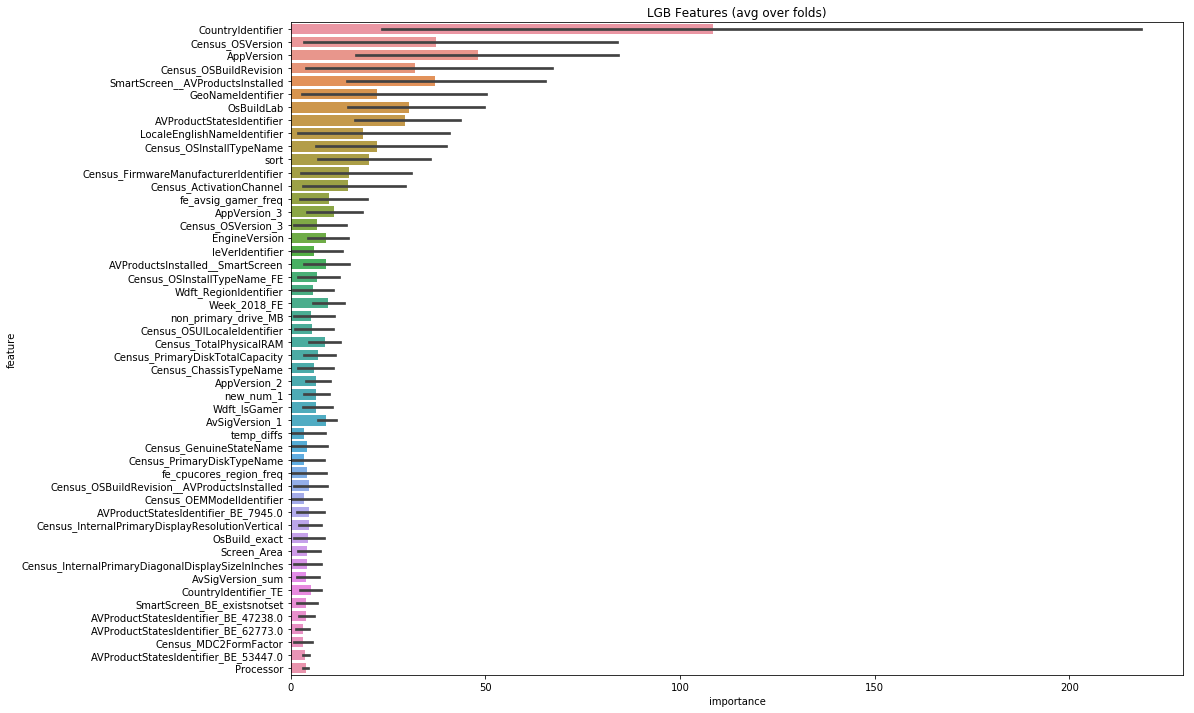

In [76]:
result_dict1 = train_model(X=train, X_test=test, y=y, params=params, model_type='lgb', plot_feature_importance=True, averaging='rank')

#result_dict['prediction']
#result_dict['oof']

In [89]:
submission = pd.read_csv('./inputs/sample_submission.csv')
submission['HasDetections'] = result_dict1['prediction']
submission.to_csv('lgb_rank-11th March.csv', index=False)

In [98]:
def save_obj(obj, name ):
    with open(''+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [99]:
import pickle

In [105]:
#result_dict1.to_csv('result_dict1.csv')()
save_obj(result_dict1,'result_dict2')

In [106]:
result_dict2 = load_obj('result_dict2')

In [78]:
#result_dict2 = train_model(X=train, X_test=test, y=y, params=params, model_type='lgb', plot_feature_importance=True, averaging='rank')

In [79]:
#submission = pd.read_csv('./inputs/sample_submission.csv')
#submission['HasDetections'] = result_dict2['prediction']
#submission.to_csv('lgb_rank2.csv', index=False)

## NFFM

In [80]:
#Download ctrNet-tool 
#You can find the code in https://github.com/guoday/ctrNet-tool
#!git clone https://github.com/guoday/ctrNet-tool.git
#!cp -r ctrNet-tool/* ./
#!rm -r ctrNet-tool data .git
#!ls -all

In [81]:
import ctrNet

In [82]:

import pandas as pd
import numpy as np
import random
import tensorflow as tf
from src import misc_utils as utils
import os
import gc
random.seed(2019)
np.random.seed(2019)

In [83]:
features = train.columns

#hparam=tf.contrib.training.HParams(
#            model='nffm',
#            norm=True,
#            batch_norm_decay=0.9,
#            hidden_size=[128,128],
#            k=8,
#            hash_ids=int(2e5),
#            batch_size=1024,
#            optimizer="adam",
#            learning_rate=0.001,
#            num_display_steps=1000,
#            num_eval_steps=1000,
#            epoch=1,
#            metric='auc',
#            init_method='uniform',
#            init_value=0.1,
#            feature_nums=len(features),
#            kfold=5)
#utils.print_hparams(hparam)


hparam=tf.contrib.training.HParams(
            model='nffm',
            norm=True,
            batch_norm_decay=0.9,
            hidden_size=[128,128],
            k=8,
            hash_ids=int(2e5),
            batch_size=1024,
            optimizer="adam",
            learning_rate=0.001,
            num_display_steps=1000,
            num_eval_steps=1000,
            steps=2000,
            epoch=1,
            metric='auc',
            init_method='uniform',
            init_value=0.1,
            feature_nums=len(features),
            kfold=5)
utils.print_hparams(hparam)


  batch_norm_decay=0.9
  batch_size=1024
  epoch=1
  feature_nums=142
  hash_ids=200000
  hidden_size=[128, 128]
  init_method=uniform
  init_value=0.1
  k=8
  kfold=5
  learning_rate=0.001
  metric=auc
  model=nffm
  norm=True
  num_display_steps=1000
  num_eval_steps=1000
  optimizer=adam


In [84]:
features = train.columns

In [85]:
train[features].shape

(8921483, 142)

In [86]:
test.shape

(7853253, 142)

In [87]:

def make_bucket(data,num=10):
    data.sort()
    bins=[]
    for i in range(num):
        bins.append(data[int(len(data)*(i+1)//num)-1])
    return bins
float_features=['Census_SystemVolumeTotalCapacity','Census_PrimaryDiskTotalCapacity']
for f in float_features:
    train[f]=train[f].fillna(1e10)
    test[f]=test[f].fillna(1e10)
    data=list(train[f])+list(test[f])
    bins=make_bucket(data,num=50)
    train[f]=np.digitize(train[f],bins=bins)
    test[f]=np.digitize(test[f],bins=bins)
    
#features=train.columns.tolist()[1:-1]

In [88]:
index=set(range(train.shape[0]))
K_fold=[]
oof = np.zeros(len(train))

for i in range(hparam.kfold):
    if i == hparam.kfold-1:
        tmp=index
    else:
        tmp=random.sample(index,int(1.0/hparam.kfold*train.shape[0]))
    index=index-set(tmp)
    print("Number:",len(tmp))
    K_fold.append(tmp)
    

for i in range(hparam.kfold):
    print("Fold",i)
    dev_index=K_fold[i]
    dev_index=random.sample(dev_index,int(0.1*len(dev_index)))
    train_index=[]
    for j in range(hparam.kfold):
        if j!=i:
            train_index+=K_fold[j]
    model=ctrNet.build_model(hparam)
    #y.iloc
    #model.train(train_data=(train.iloc[train_index][features],train.iloc[train_index]['HasDetections']),\
    #            dev_data=(train.iloc[dev_index][features],train.iloc[dev_index]['HasDetections']))

    model.train(train_data=(train.iloc[train_index][features],y.iloc[train_index]),dev_data=(train.iloc[dev_index][features],y.iloc[dev_index]))
    
    #oof[dev_index] = model.predict(train.iloc[dev_index][features], num_iteration=model.best_iteration)
    #oof[dev_index] = model.infer((train.iloc[dev_index][features],y.iloc[dev_index]))


    #print("Training Done! Inference...")
    #if i==0:
    #    preds=model.infer(dev_data=(test[features],ytest))/hparam.kfold
    #else:
    #    preds+=model.infer(dev_data=(test[features],ytest))/hparam.kfold

Number: 1784296
Number: 1784296
Number: 1784296
Number: 1784296
Number: 1784299
Fold 0
# Trainable variables
  emb_v1:0, (200000, 1), 
  emb_v2:0, (200000, 142, 8), 
  Variable:0, (10011, 128), 
  norm_0/beta:0, (128,), 
  norm_0/gamma:0, (128,), 
  Variable_1:0, (128, 128), 
  norm_1/beta:0, (128,), 
  norm_1/gamma:0, (128,), 
  Variable_2:0, (128, 1), 
  Variable_3:0, (), 
  epoch 0 step 1000 lr 0.001 logloss 0.626691 gN 0.23, Sun Mar 10 23:14:26 2019
# Epcho-time 5071.10s Eval AUC 0.727259. Best AUC 0.727259.
  epoch 0 step 2000 lr 0.001 logloss 0.602055 gN 0.16, Mon Mar 11 01:16:33 2019
# Epcho-time 12398.40s Eval AUC 0.733014. Best AUC 0.733014.
  epoch 0 step 3000 lr 0.001 logloss 0.598732 gN 0.15, Mon Mar 11 02:44:22 2019
# Epcho-time 17667.78s Eval AUC 0.736881. Best AUC 0.736881.
  epoch 0 step 4000 lr 0.001 logloss 0.595949 gN 0.14, Mon Mar 11 04:13:38 2019
# Epcho-time 23023.75s Eval AUC 0.736710. Best AUC 0.736881.
  epoch 0 step 5000 lr 0.001 logloss 0.594297 gN 0.14, Mon 

KeyboardInterrupt: 

In [ ]:
len(test)

In [ ]:
#oof = model.infer((train[features],y))

# PREDICT IN CHUNKS FOR REDUCED MEMORY USAGE
idx = 0; chunk = 2000000
while idx < len(test) -1:
    idx2 = min(idx + chunk, len(test) )
    idx = range(idx, idx2)
    #oof[idx] = model.predict_proba(test.iloc[idx])[:,1]
    #print(train[features].iloc[idx])
    #print(y.iloc[idx])
    
    oof[idx] = model.infer((train[features].iloc[idx],y.iloc[idx])) #[:,1]
    idx = idx2

In [ ]:
oof
#preds

In [ ]:
from sklearn.linear_model import Ridge, BayesianRidge
#,predictions_xgb
#,oof_xgb

#result_dict['prediction']
#result_dict['oof']

#train_stack = np.vstack([oof_preds, oof_lgb,oof]).transpose()
#test_stack = np.vstack([sub_preds,predictions_lgb,predictions]).transpose()

#train_stack = np.vstack([result_dict1['oof'], result_dict2['oof'],result_dict3['oof'],result_dict4['oof']]).transpose()
#test_stack = np.vstack([result_dict1['prediction'],result_dict2['prediction'],result_dict3['prediction'],result_dict4['prediction']]).transpose()

#train_stack = np.vstack([result_dict1['oof'], result_dict2['oof']]).transpose()
#test_stack = np.vstack([result_dict1['prediction'],result_dict2['prediction']]).transpose()

target = y
train_stack = np.vstack([result_dict1['oof'], oof]).transpose()
test_stack = np.vstack([result_dict1['prediction'],preds]).transpose()


folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    print("-" * 10 + "Ridge Regression" + str(fold_) + "-" * 10)
#     cb_model = CatBoostRegressor(iterations=3000, learning_rate=0.1, depth=8, l2_leaf_reg=20, bootstrap_type='Bernoulli',  eval_metric='RMSE', metric_period=50, od_type='Iter', od_wait=45, random_seed=17, allow_writing_files=False)
#     cb_model.fit(trn_data, trn_y, eval_set=(val_data, val_y), cat_features=[], use_best_model=True, verbose=True)
    clf = Ridge(alpha=100)
    clf.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf.predict(val_data)
    predictions_stack += clf.predict(test_stack) / 5


np.sqrt(mean_squared_error(target.values, oof))

In [ ]:
submission = pd.read_csv('./inputs/sample_submission.csv')
submission['HasDetections'] = predictions_stack
submission.to_csv('lgb_rank2.csv', index=False)

#sub_df = pd.DataFrame({"MachineIdentifier": test["MachineIdentifier"].values})
#sub_df["HasDetections"] = predictions_stack

#sub_df.to_csv('MS-Stack-March-3rd.csv', index=False) #3.706

In [84]:
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold

xgb_params = {'eta': 0.005, 'boosting': 'gbdt' ,'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'alpha':0.1,
          'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'random_state':5}

#train1=train11
#target=y1,
features = train11.columns

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof_xgb = np.zeros(len(train1))
predictions_xgb = np.zeros(len(test))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(train1,y1.values)):
    print("fold {}".format(fold_))
    print("fold n°{}".format(fold_ + 1))
    trn_data = xgb.DMatrix(data=train1.iloc[trn_idx][features], label=y1.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train1.iloc[val_idx][features], label=y1.iloc[val_idx])
    
    watchlist = [(trn_data, 'train1'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 5000
    
    xgb_model = xgb.train1(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=100, verbose_eval=100)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(train1.iloc[val_idx][features]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb += xgb_model.predict(xgb.DMatrix(test[features]), ntree_limit=xgb_model.best_ntree_limit+50) / 10
    
np.save('oof_xgb', oof_xgb)
np.save('predictions_xgb', predictions_xgb)
print("AUC : ",np.sqrt(mean_squared_error(y1.values, oof_xgb)))
gc.collect()

fold 0
fold n°1
xgb 0--------------------------------------------------
[0]	train-auc:0.670641	valid-auc:0.647712
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.69114	valid-auc:0.667575
[200]	train-auc:0.695845	valid-auc:0.670202
[300]	train-auc:0.702188	valid-auc:0.672834
[400]	train-auc:0.707889	valid-auc:0.674781
[500]	train-auc:0.713758	valid-auc:0.676624
[600]	train-auc:0.72043	valid-auc:0.678391
[700]	train-auc:0.726292	valid-auc:0.679891
[800]	train-auc:0.731725	valid-auc:0.680938
[900]	train-auc:0.737177	valid-auc:0.682073
[1000]	train-auc:0.741924	valid-auc:0.682761
[1100]	train-auc:0.746489	valid-auc:0.683202
[1200]	train-auc:0.750585	valid-auc:0.683649
[1300]	train-auc:0.754698	valid-auc:0.684065
[1400]	train-auc:0.75848	valid-auc:0.684377
[1500]	train-auc:0.762313	valid-auc:0.684902
[1600]	train-auc:0.765886	valid-auc:0.685063
[1700]	train-auc:0.76946	valid-auc

AttributeError: 'tuple' object has no attribute 'values'

### XGB

In [ ]:
np.save(train['MachineIdentifier'], 'train_ids.npy')
np.save(test['MachineIdentifier'], 'test_ids.npy')
np.save(train['features'], 'train_dataset.npy')
np.save(test['features'], 'test_dataset.npy')
np.save(train['HasDetections'], 'train_target.npy')

In [ ]:
from sklearn.externals import joblib
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold

train = np.load('train_dataset.npy')
y = np.load('train_target.npy')


xgb_params = {'eta': 0.005, 'boosting': 'gbdt' ,'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'alpha':0.1,
          'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'random_state':5}


for fold_, (trn_, val_) in enumerate(folds.split(y, y)):

    print('splitting', datetime.now())
    trn_x, trn_y = train[trn_], y[trn_]
    val_x, val_y = train[val_], y[val_]

    clf = xgb.XGBClassifier(
        **xgb_params,
    )

    print('Training ', datetime.now())
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        verbose=50,
        early_stopping_rounds=20
    )

    oof_preds[val_] = clf.predict_proba(val_x, ntree_limit=clf.best_ntree_limit)[:, 1]
    # Use CPMP code, really runs faster
    print(fast_auc(val_y, oof_preds[val_]))

    # Store XGBoost model
    # Looks like XGBClassifier keeps a handle to the eval sets so deleting trn_x and val_x is useless
    # they stay in memory and no garbage collection occurs
    # So we dump the Classifier and delete it before garbage collection
    joblib.dump(clf, 'xgboost_model_fold_%d.gz' % (fold_ + 1))

    # Garbage collect
    # You need to delete clf first. If you do it at the end, delete will tell you 
    # handles to eval sets and trainng data can't be deleted ...
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()

In [ ]:
test = np.load('test_dataset.npy')

clfs = [
    joblib.load('xgboost_001_model_032_dataset_fold_%d.gz' % (i+1))
    for i in range(folds.n_splits)
]

for clf in clfs:
    test_sub += clf.predict_proba(test, ntree_limit=clf.best_ntree_limit)[:, 1] / len(clfs)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold

xgb_params = {'eta': 0.005, 'boosting': 'gbdt' ,'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'alpha':0.1,
          'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'random_state':5}

#train=train1
#target=y1,
features = train1.columns

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,y.values)):
    print("fold {}".format(fold_))
    print("fold n°{}".format(fold_ + 1))
    trn_data = xgb.DMatrix(data=train.iloc[trn_idx][features], label=y.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train.iloc[val_idx][features], label=y.iloc[val_idx])
    
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 5000
    
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=100, verbose_eval=100)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx][features]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb += xgb_model.predict(xgb.DMatrix(test[features]), ntree_limit=xgb_model.best_ntree_limit+50) / 10
    
np.save('oof_xgb', oof_xgb)
np.save('predictions_xgb', predictions_xgb)
print("AUC : ",np.sqrt(mean_squared_error(y.values, oof_xgb)))
gc.collect()

In [ ]:
submission = pd.read_csv('./inputs/sample_submission.csv')
submission['HasDetections'] = result_dict4['prediction']
submission.to_csv('cat_rank.csv', index=False)

In [72]:
#from catboost import CatBoostClassifier

In [73]:
#result_dict4 = train_model(X=train1, X_test=test, y=y1, params=params, model_type='cat', plot_feature_importance=True, averaging='rank')


In [ ]:
#submission = pd.read_csv('./inputs/sample_submission.csv')
#submission['HasDetections'] = result_dict2['prediction']
#submission.to_csv('xgb_rank.csv', index=False)

In [71]:
#result_dict3 = train_model(X=train1, X_test=test, y=y1, params=params, model_type='lcv', plot_feature_importance=True, averaging='rank')

In [ ]:
#submission = pd.read_csv('./inputs/sample_submission.csv')
#submission['HasDetections'] = result_dict3['prediction']
#submission.to_csv('lcv_rank.csv', index=False)

<a id="2.2"></a> <br>
### 2.2 Define the type of each variable
In practice, among the numerical variables, many corresponds to identifiers. *In the current dataset, the truly numerical variables are in fact rare*. Below, I make a list of the variables which are truly numerical, according the the description of the data.

In [7]:
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]

We also list binary variables, since they can be treated as numericals by tree methods:

In [8]:
binary_variables = [c for c in train.columns if train[c].nunique() == 2]

to finally make a census of the categorical variables:

In [9]:
categorical_columns = [c for c in train.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]

In [10]:
variables = {
    'categorical_columns': len(categorical_columns),
    'binary_variables': len(binary_variables),
    'true_numerical_columns': len(true_numerical_columns)
}
pie_trace = go.Pie(labels=list(variables.keys()), values=list(variables.values()))
layout = dict(title= "Variable types", height=400, width=800)
fig = dict(data=[pie_trace], layout=layout)
iplot(fig)

Most of the current variables are categories and we need to choose a method to treat them. **Depending on the cardinality of each variable**, we can opt for** one-hot-encoding, frequency or target encoding**. In the particular case of Light-GBM, we can also use the **built-in LGBM treatment of categoricals**:

In [11]:
cardinality = []
for c in categorical_columns:
    if c == 'MachineIdentifier': continue
    cardinality.append([c, train[c].nunique()])
cardinality.sort(key = lambda x:x[1], reverse=False)

trace = go.Bar(y=[x[0] for x in cardinality],
               x=[x[1] for x in cardinality],
               orientation='h', marker=dict(color='rgb(49,130,189)'), name='train')

layout = go.Layout(
    title='Categorical cardinality', height=1600, width=800,
    xaxis=dict(
        title='Number of categories',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]
    ),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

<a id="2"></a> <br>
## 3. Feature Engineering
<a id="3.1"></a> <br>
### 3.1 Frequency encoding
For variables with large cardinality, an efficient encoding consists in ranking the categories with respect to their frequencies. These variables are then treated as numerical.

In [12]:
def frequency_encoding(variable):
    t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [13]:
frequency_encoded_variables = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'Census_ProcessorModelIdentifier',
    'Census_OEMNameIdentifier',
    'DefaultBrowsersIdentifier'
]

In [14]:
for variable in tqdm(frequency_encoded_variables):
    freq_enc_dict = frequency_encoding(variable)
    train[variable] = train[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    test[variable] = test[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    categorical_columns.remove(variable)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:30<00:00,  4.26s/it]


<a id="3.2"></a> <br>
### 3.2 Label encoding

In [15]:
indexer = {}
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    _, indexer[col] = pd.factorize(train[col])
    
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    train[col] = indexer[col].get_indexer(train[col])
    test[col] = indexer[col].get_indexer(test[col])

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [18:34<00:00, 12.02s/it]


In [16]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 694.06 Mb (66.7% reduction)
Mem. usage decreased to 1361.03 Mb (66.7% reduction)


In [17]:
train[:5]

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,0,0,0,249.0,0,0,0,NaN,0,0,0,1,0,210.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,-1,0.0,0,-1,1.0,0,0,0,0.0,21627.0,4.0,0,137.0,-1,476940.0,0,299451.0,0,4096.0,0,18.906250,1440.0,900.0,0,-1,4.294967e+09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,0,NaN,0,2656.0,0,-1,0.0,0,0,0.0,0.0,0,0
1,000007535c3f730efa9ea0b7ef1bd645,0,1,1,0.0,0,0,0,NaN,0,0,0,1,1,173.0,0,1,1,0,0,0,0,0,0,0,0,1.0,0,-1,0.0,0,-1,1.0,0,1,0,0.0,110446.0,4.0,0,110.0,-1,476940.0,0,102385.0,0,4096.0,1,13.898438,1366.0,768.0,1,-1,1.000000e+00,1,0,0,0,1,0,0,1,1,1,0,0,1,0,NaN,0.0,1,NaN,0,1292.0,0,-1,0.0,0,0,0.0,0.0,1,0
2,000007905a28d863f6d0d597892cd692,0,0,0,635.0,0,0,0,NaN,0,0,0,1,2,675.0,0,2,2,0,0,0,0,1,0,0,1,1.0,0,-1,0.0,0,0,1.0,0,0,0,10.0,2.0,4.0,0,189.0,-1,114473.0,1,113907.0,0,4096.0,0,21.500000,1920.0,1080.0,0,-1,4.294967e+09,0,0,0,0,0,1,1,0,2,2,1,0,0,1,NaN,0.0,0,NaN,1,180.0,0,-1,0.0,0,0,0.0,0.0,2,0
3,00000b11598a75ea8ba1beea8459149f,0,0,0,73.0,0,0,0,NaN,0,0,0,1,3,20.0,-1,3,3,0,0,0,0,0,0,0,0,1.0,0,-1,0.0,0,1,1.0,0,0,0,2.0,152.0,4.0,0,59.0,-1,238475.0,2,227116.0,0,4096.0,2,18.500000,1366.0,768.0,0,-1,4.294967e+09,2,0,0,0,2,0,0,0,3,3,1,0,0,1,NaN,0.0,0,NaN,2,30.0,0,-1,0.0,0,0,0.0,0.0,2,1
4,000014a5f00daa18e76b81417eeb99fc,0,0,0,51.0,0,0,0,NaN,0,0,0,1,4,12.0,-1,4,4,0,0,0,0,1,0,0,1,1.0,0,-1,0.0,0,0,1.0,0,1,0,2.0,2290.0,4.0,0,53.0,-1,476940.0,0,101900.0,0,6144.0,3,14.000000,1366.0,768.0,1,0,0.000000e+00,3,0,0,0,3,1,1,2,1,1,1,0,0,0,0.0,0.0,0,0.0,2,130.0,0,0,0.0,0,0,0.0,0.0,3,1


In [18]:
target = train['HasDetections']
del train['HasDetections']

<a id="3"></a> <br>
## 3. Training the model

In [19]:
param = {'num_leaves': 60,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

We set the max number of iteration over folds:

In [20]:
max_iter = 5

In [21]:
gc.collect()

210

In [41]:
categorical_columns = [c for c in categorical_columns if c not in ['MachineIdentifier']]
features = [c for c in train.columns if c not in ['MachineIdentifier']]


In [22]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))

categorical_columns = [c for c in categorical_columns if c not in ['MachineIdentifier']]
features = [c for c in train.columns if c not in ['MachineIdentifier']]

predictions = np.zeros(len(test))
start = time.time()

feature_importance_df = pd.DataFrame()
start_time= time.time()
score = [0 for _ in range(folds.n_splits)]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature = categorical_columns
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature = categorical_columns
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # we perform predictions by chunks
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))

    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = clf.predict(test.iloc[idx][features], num_iteration=clf.best_iteration)
        initial_idx = final_idx
    predictions += current_pred / min(folds.n_splits, max_iter)
   
    print("time elapsed: {:<5.2}s".format((time.time() - start_time) / 3600))
    score[fold_] = metrics.roc_auc_score(target.iloc[val_idx], oof[val_idx])
    if fold_ == max_iter - 1: break
        
if (folds.n_splits == max_iter):
    print("CV score: {:<8.5f}".format(metrics.roc_auc_score(target, oof)))
else:
     print("CV score: {:<8.5f}".format(sum(score) / max_iter))

fold n°0


C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.734562	valid_1's auc: 0.727633
[200]	training's auc: 0.744336	valid_1's auc: 0.731325
[300]	training's auc: 0.750249	valid_1's auc: 0.732434
[400]	training's auc: 0.754375	valid_1's auc: 0.732808
[500]	training's auc: 0.757818	valid_1's auc: 0.732781
[600]	training's auc: 0.760918	valid_1's auc: 0.732738
[700]	training's auc: 0.763726	valid_1's auc: 0.732675
Early stopping, best iteration is:
[563]	training's auc: 0.759867	valid_1's auc: 0.732839
time elapsed: 0.3  s
fold n°1


C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.734545	valid_1's auc: 0.727246
[200]	training's auc: 0.744022	valid_1's auc: 0.730666
[300]	training's auc: 0.750011	valid_1's auc: 0.732056
[400]	training's auc: 0.75419	valid_1's auc: 0.732473
[500]	training's auc: 0.75776	valid_1's auc: 0.732539
[600]	training's auc: 0.760816	valid_1's auc: 0.732496
Early stopping, best iteration is:
[476]	training's auc: 0.757036	valid_1's auc: 0.732588
time elapsed: 0.57 s
fold n°2


C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.734728	valid_1's auc: 0.726721
[200]	training's auc: 0.744455	valid_1's auc: 0.730236
[300]	training's auc: 0.750457	valid_1's auc: 0.731519
[400]	training's auc: 0.754631	valid_1's auc: 0.731846
[500]	training's auc: 0.758308	valid_1's auc: 0.731964
[600]	training's auc: 0.761427	valid_1's auc: 0.731976
[700]	training's auc: 0.764216	valid_1's auc: 0.731991
Early stopping, best iteration is:
[569]	training's auc: 0.760558	valid_1's auc: 0.732057
time elapsed: 0.89 s
fold n°3


C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.735041	valid_1's auc: 0.726187
[200]	training's auc: 0.744481	valid_1's auc: 0.729701
[300]	training's auc: 0.750165	valid_1's auc: 0.730785
[400]	training's auc: 0.754546	valid_1's auc: 0.731216
[500]	training's auc: 0.758174	valid_1's auc: 0.731454
[600]	training's auc: 0.761374	valid_1's auc: 0.73155
[700]	training's auc: 0.764136	valid_1's auc: 0.731392
Early stopping, best iteration is:
[553]	training's auc: 0.76	valid_1's auc: 0.73156
time elapsed: 1.2  s
fold n°4


C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\lightgbm\basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\lightgbm\basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.734634	valid_1's auc: 0.7277
[200]	training's auc: 0.744108	valid_1's auc: 0.730977
[300]	training's auc: 0.749708	valid_1's auc: 0.731897
[400]	training's auc: 0.753987	valid_1's auc: 0.732262
[500]	training's auc: 0.757351	valid_1's auc: 0.732268
[600]	training's auc: 0.760478	valid_1's auc: 0.732284
[700]	training's auc: 0.763261	valid_1's auc: 0.732166
Early stopping, best iteration is:
[551]	training's auc: 0.759062	valid_1's auc: 0.732373
time elapsed: 1.5  s
CV score: 0.73228 


<a id="4"></a> <br>
## 4. Feature importance

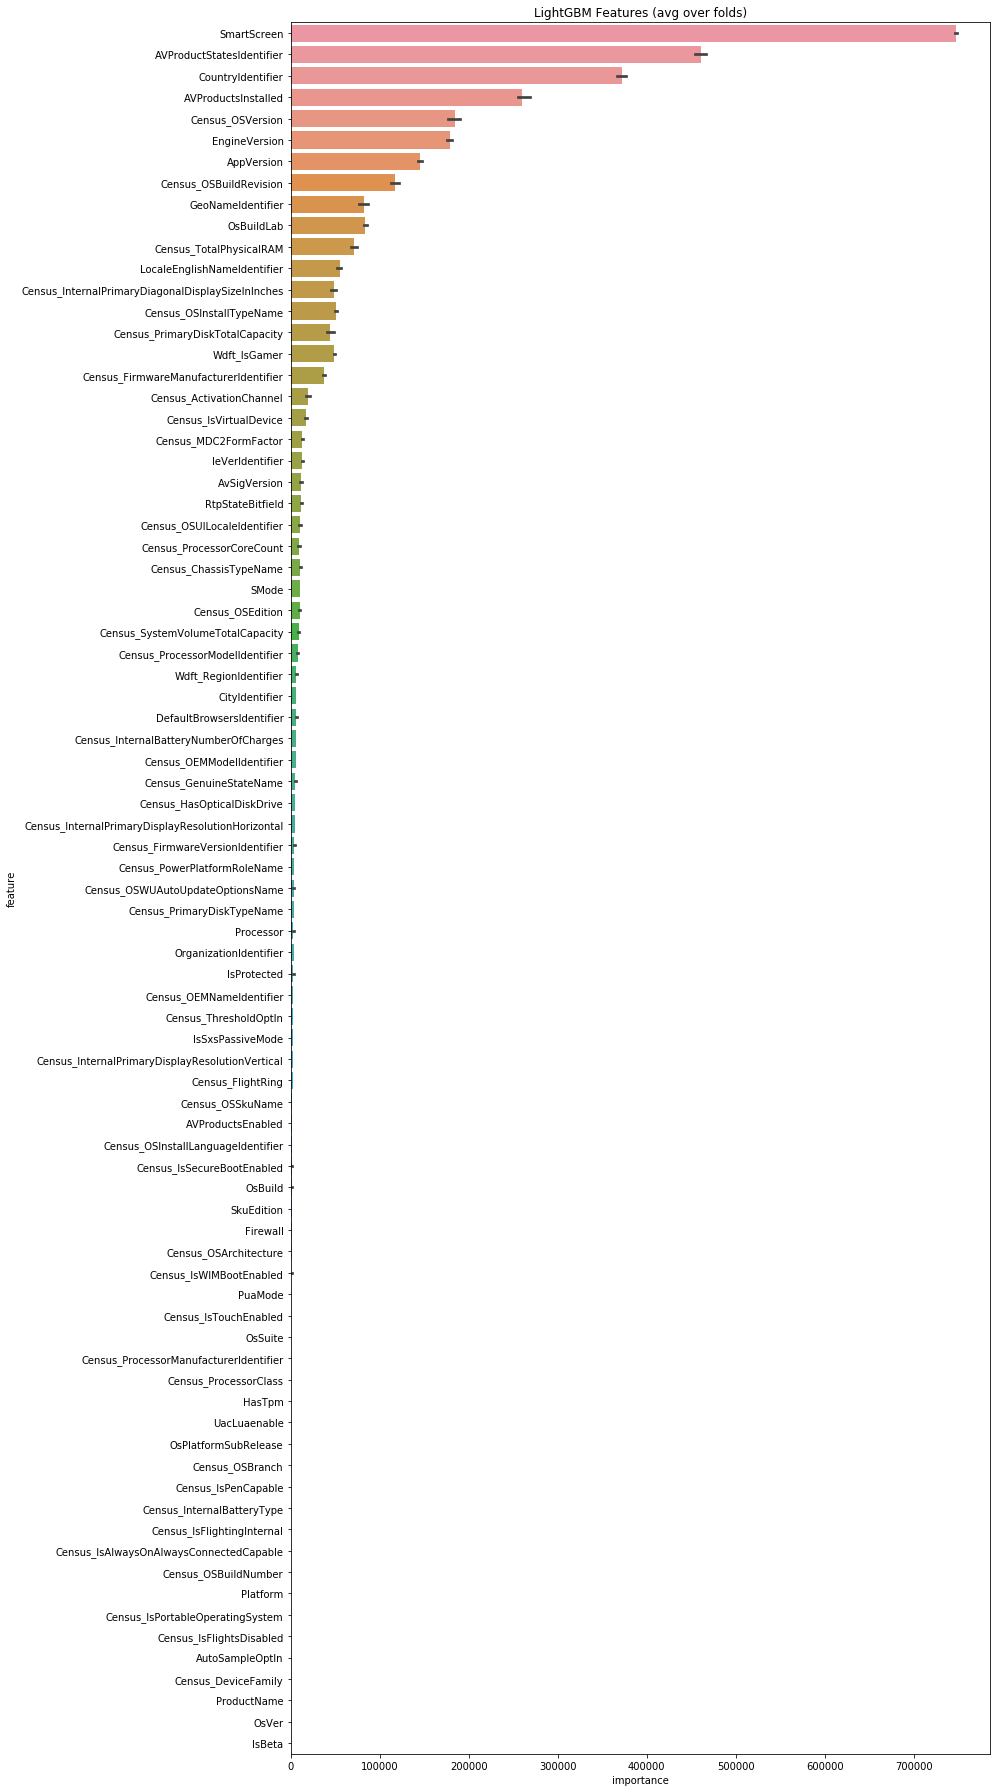

In [23]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

<a id="5"></a> <br>
## 5. Submission

In [24]:
sub_df = pd.DataFrame({"MachineIdentifier": test["MachineIdentifier"].values})
sub_df["HasDetections"] = predictions
sub_df[:10]

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.550966
1,00000176ac758d54827acd545b6315a5,0.480217
2,0000019dcefc128c2d4387c1273dae1d,0.413183
3,0000055553dc51b1295785415f1a224d,0.307735
4,00000574cefffeca83ec8adf9285b2bf,0.420262
5,000007ffedd31948f08e6c16da31f6d1,0.544406
6,000008f31610018d898e5f315cdf1bd1,0.273887
7,00000a3c447250626dbcc628c9cbc460,0.180477
8,00000b6bf217ec9aef0f68d5c6705897,0.482377
9,00000b8d3776b13e93ad83676a28e4aa,0.296342


In [25]:
sub_df.to_csv("submit.csv", index=False)

In [ ]:
#0.73228  = 0.6781

In [ ]:
## NEW

In [ ]:
# If you call encode_TE, encode_TE_partial, encode_FE_partial, 
# or encode_BE_partial on training data then the function 
# returns a 2 element python list containing [list, dictionary]
# the return[0] = list are the names of new columns added
# the return[1] = dictionary are which category variables got encoded
# When encoding test data after one of 4 calls above, use 'encode_?E_test'
# and pass the dictionary. If you don't use one of 4 above, then you can
# call basic 'encode_?E' on test.

# TARGET ENCODING
def encode_TE(df,col,tar='HasDetections'):
    d = {}
    v = df[col].unique()
    for x in v:
        if nan_check(x):
            m = df[tar][df[col].isna()].mean()
        else:
            m = df[tar][df[col]==x].mean()
        d[x] = m
    n = col+"_TE"
    df[n] = df[col].map(d)
    return [[n],d]

# TARGET ENCODING first ct columns by freq
def encode_TE_partial(df,col,ct,tar='HasDetections',xx=0.5):
    d = {}
    cv = df[col].value_counts(dropna=False)
    nm = cv.index.values[0:ct]
    for x in nm:
        if nan_check(x):
            m = df[tar][df[col].isna()].mean()
        else:
            m = df[tar][df[col]==x].mean()
        d[x] = m
    n = col+"_TE"
    df[n] = df[col].map(d).fillna(xx)
    return [[n],d]

# TARGET ENCODING from dictionary
def encode_TE_test(df,col,mp,xx=0.5):
    n = col+"_TE"
    df[n] = df[col].map(mp).fillna(xx)
    return [[n],0]

# FREQUENCY ENCODING
def encode_FE(df,col):
    d = df[col].value_counts(dropna=False)
    n = col+"_FE"
    df[n] = df[col].map(d)/d.max()
    return [[n],d]

# FREQUENCY ENCODING first ct columns by freq
def encode_FE_partial(df,col,ct):
    cv = df[col].value_counts(dropna=False)
    nm = cv.index.values[0:ct]
    n = col+"_FE"
    df[n] = df[col].map(cv)
    df.loc[~df[col].isin(nm),n] = np.mean(cv.values)
    df[n] = df[n] / max(cv.values)
    d = {}
    for x in nm: d[x] = cv[x]
    return [[n],d]

# FREQUENCY ENCODING from dictionary
def encode_FE_test(df,col,mp,xx=1.0):
    cv = df[col].value_counts(dropna=False)
    n = col+"_FE"
    df[n] = df[col].map(cv)
    df.loc[~df[col].isin(mp),n] = xx*np.mean(cv.values)
    df[n] = df[n] / max(cv.values)
    return [[n],mp]

# BINARY ENCODING
def encode_BE(df,col,val='xyz'):
    if val=='xyz':
        print('BE_encoding all')
        v = df[col].unique()
        n = []
        for x in v: n.append(encode_BE(df,col,x)[0][0])
        return [n,0]
    n = col+"_BE_"+str(val)
    if nan_check(val):
        df[n] = df[col].isna()
    elif isinstance(val, (list,)):
        if not isinstance(val[0], str):
            print('BE_encode Warning: val list not str')
        n = col+"_BE_"+str(val[0])+"_"+str(val[-1])
        d = {}
        for x in val: d[x]=1
        df[n] = df[col].map(d).fillna(0)
    else:
        if not isinstance(val, str):
            print('BE_encode Warning: val is not str')
        df[n] = df[col]==val
    df[n] = df[n].astype('int8')
    return [[n],0]

# BINARY ENCODING first ct columns by freq
def encode_BE_partial(df,col,ct):
    cv = df[col].value_counts(dropna=False)
    nm = cv.index.values[0:ct]
    d = {}
    n = []
    for x in nm: 
        n.append(encode_BE(df,col,x)[0][0])
        d[x] = 1
    return [n,d]

# BINARY ENCODING from dictionary
def encode_BE_test(df,col,mp):
    n = []
    for x in mp: n.append(encode_BE(df,col,x)[0][0])
    return [n,0]

# NUMERIC ENCODING
def encode_NE(df,col):
    n = col+"_NE"
    df[n] = df[col].astype(float)
    mx = np.std(df[n])
    mn = df[n].mean()
    df[n] = (df[n].fillna(mn) - mn) / mx
    return [[n],[mn,mx]]

# NUMERIC ENCODING from mean and std
def encode_NE_test(df,col,mm):
    n = col+"_NE"
    df[n] = df[col].astype(float)
    df[n] = (df[n].fillna(df[n].mean()) - mm[0]) / mm[1]
    return [[n],mm]

In [ ]:
cols = []

# NUMERIC ENCODE
cols += encode_NE(df_train,'Census_TotalPhysicalRAM')[0]
cols += encode_NE(df_train,'AVProductsInstalled')[0]
cols += encode_NE(df_train,'Census_ProcessorCoreCount')[0]

# CATEGORY ENCODE for logistic regression
tmp = encode_BE_partial(df_train,'SmartScreen',5)
cols += tmp[0]; dict_smartscreen = tmp[1]
tmp = encode_BE_partial(df_train,'AVProductStatesIdentifier',5)
cols += tmp[0]; dict_productstate = tmp[1]

# BINARY ENCODE
cols += encode_BE(df_train,'Processor','x86')[0]
cols += encode_BE(df_train,'Census_IsTouchEnabled','1')[0]
cols += encode_BE(df_train,'Census_HasOpticalDiskDrive','1')[0]
cols += encode_BE(df_train,'Census_InternalPrimaryDisplayResolutionVertical',['800','600'])[0]
cols += encode_BE(df_train,'Census_PowerPlatformRoleName','Slate')[0]
cols += encode_BE(df_train,'Wdft_IsGamer','1')[0]

#FREQUENCY ENCODE
cols += encode_FE(df_train,'Census_ProcessorModelIdentifier')[0]
cols += encode_FE(df_train,'Week')[0]
#FREQUENCY ENCODE remove noise
tmp = encode_FE_partial(df_train,'Census_OSInstallTypeName',7)
cols += tmp[0]; dict_osinstalltype = tmp[1]

#TARGET ENCODE remove noise
tmp = encode_TE_partial(df_train,'CountryIdentifier',150)
cols += tmp[0]; dict_country = tmp[1]
tmp = encode_TE_partial(df_train,'OsBuild',5)
cols += tmp[0]; dict_osbuild = tmp[1]

In [ ]:
import statsmodels.api as sm

logr = sm.Logit(df_train['HasDetections'], df_train[cols])
logr = logr.fit(disp=0)
df_train['Prob'] = logr.predict(df_train[cols])
print('Training complete')

In [ ]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(df_train['HasDetections'].values, df_train['Prob'].values)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# PREDICT
df_test['HasDetections'] = logr.predict(df_test[cols])
# SUBMIT
df_test[['MachineIdentifier','HasDetections']].to_csv('submission.csv', index=False)